# Pulse-level circuit simulation with QuTiP

Author: Boxi Li (etamin1201@gmail.com)

This is the introduction notebook to the deliverable of one of the Google Summer of Code 2019 project (GSoC2019) "Noise Models in QIP Module", under the organization NumFocus. The final product of the project is a framework of noisy quantum device simulator based on QuTiP open system solvers.

The simulation of quantum information processing (QIP) is usually achieved by gate matrix product. Many simulators such as the simulation backend of Qiskit and porjectQ are based on it. QuTiP offers this common way of simulation with the class `qutit.qip.QubitCircuit`. It simulates QIP in the circuit model. You can find the introduction notebook for this matrix gate representation [here](quantum-gates.ipynb).

The simulation introduced here is different as it simulates the dynamics of the quantum device at the level of driving Hamiltonians. It is closer to the physical realization than the matrix product approach and is more convenient when simulating the noise of physical hardware. The simulator is based on QuTiP Lindbladian equation solvers and is defined as `qutip.qip.device.Processor`. The basic element is the control pulse characterized by the driving Hamiltonian, target qubits, time sequence and pulse strength. Our way of simulation offers a practical way to diagnostically add noise to each pulse or the whole device at the Hamiltonian level. Based on this pulse level control, different backends can be defined for different physical systems such as Cavity QED, Ion trap or Circuit QED. For each backend, a compiler needs to be defined. In the end, the `Processor` will be able to transfer a simple quantum circuit into the control pulse sequence, add noise automatically and perform the noisy simulation.

This notebook contains the most basic part of this quantum device simulator, i.e. the noisy evolution under given control pulses. It demonstrates how to set up the parameters and introduce different kinds of noise into the evolution.

### Note
This module is still under active development. Be ready for some adventures and unexpected edges. Please do not hesitate to raise an issue on our GitHub website if you find any bugs. A new release might break some backwards compatibility on this module, therefore we recommend you to check our GitHub website if you are facing some unexpected errors after an update.

## Links to other related notebook
There is a series of notebooks on specialized subclasses and application of the simulator `Processor`, including finding pulses realizing certain quantum gate based on optimization algorithm or physical model and simulating simple quantum algorithms:

The notebook [QuTiP example: Physical implementation of Spin Chain Qubit model](spin-chain-model.ipynb) shows the simulation of a spin-chain based quantum computing model both with `qutit.qip.QubitCircuit` and `qutip.qip.device.Processor`.

The notebook [Examples for OptPulseProcessor](qip-optpulseprocessor.ipynb) describes the class `OptPulseProcessor`, which uses the optimal control module in QuTiP to find the control pulses for quantum gates.

The notebook [Running the Deutsch–Jozsa algorithm on the noisy device simulator
](qip-processor-DJ-algorithm.ipynb) gives an example of simulating simple quantum algorithms in the presence of noise.

The notebook [Simulating your own quantum device](qip-customize-device.ipynb) provides a step-by-step guide on how to customize the simulator to simulate your own quantum devices.

## The pulse level control


In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
pi = np.pi

from qutip.qip.device import Processor
from qutip.operators import sigmaz, sigmay, sigmax, destroy
from qutip.states import basis
from qutip.metrics import fidelity
from qutip.qip.operations import rx, ry, rz, hadamard_transform

### Controlling a single qubit
The simulation of a unitary evolution with `Processor` is defiend by the control pulses. Each pulse is represented by a `Pulse` object consisting of the control Hamiltonian $H_j$, the target qubits, the pulse strength $c_j$ and the time sequence $t$. The evolution is given by 

\begin{equation}
U(t)=\exp(-\mathrm{i} \sum_j c_j(t) H_j t)
\end{equation}

In this example, we define a single-qubit quantum device with $\sigma_z$ and $\sigma_y$ pulses.

In [2]:
processor = Processor(N=1)
processor.add_control(0.5 * sigmaz(), targets=0, label="sigmaz")
processor.add_control(0.5 * sigmay(), targets=0, label="sigmay")

The list of defined pulses are saved in an attribute `Processor.pulses`. We can see the pulse that we just defined by

In [3]:
for pulse in processor.pulses:
    pulse.print_info()

----------------------------------------------------------------------
Pulse label: sigmaz
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]], 'targets': [0], 'tlist': None, 'coeff': None}
----------------------------------------------------------------------
----------------------------------------------------------------------
Pulse label: sigmay
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j  0.-0.5j]
 [0.+0.5j 0.+0.j ]], 'targets': [0], 'tlist': None, 'coeff': None}
----------------------------------------------------------------------


We can see that the pulse strength `coeff` and time sequence `tlist` still remain undefined. To fully characterize the evolution, we need to define them both.

The pulse strength and time are both given as a NumPy array. For discrete pulses, `tlist` specifies the start and the end time of each pulse coefficient, and thus is one element longer than `coeff`. (This is different from the usual requirement in QuTiP solver where `tlist` and `coeff` needs to have the same length.) The definition below means that we turn on the $\sigma_y$ pulse for $t=\pi$ and with strength 1. (Notice that the Hamiltonian is $H=\frac{1}{2} \sigma_z$)

In [4]:
processor.pulses[1].coeff = np.array([1.])
processor.pulses[1].tlist = np.array([0., pi])
for pulse in processor.pulses:
    pulse.print_info()

----------------------------------------------------------------------
Pulse label: sigmaz
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]], 'targets': [0], 'tlist': None, 'coeff': None}
----------------------------------------------------------------------
----------------------------------------------------------------------
Pulse label: sigmay
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j  0.-0.5j]
 [0.+0.5j 0.+0.j ]], 'targets': [0], 'tlist': array([0.        , 3.14159265]), 'coeff': array([1.])}
----------------------------------------------------------------------


This pulse is a $\pi$ pulse that flips the qubit from $\left |0 \right\rangle$ to $\left |1 \right\rangle$, equivalent to a rotation around y-axis of angle $\pi$:

$$R_y(\theta) = \begin{pmatrix} cos(\theta/2) & -sin(\theta/2) \\ sin(\theta/2) & cos(\theta/2) \end{pmatrix}$$

We can run the simulation to see the result of the evolution starting from $\left |0 \right\rangle$:

In [5]:
basis0 = basis(2, 0)
result = processor.run_state(init_state=basis0)
result.states[-1].tidyup(1.e-5)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

As arbitrary single-qubit gate can be decomposed into $R_z(\theta_1) \cdot R_y(\theta_2) \cdot R_z(\theta_3)$, it is enough to use three pulses. For demonstration purpose, we choose $\theta_1=\theta_2=\theta_3=\pi/2$

In [6]:
processor.pulses[0].coeff = np.array([1., 0., 1.])
processor.pulses[1].coeff = np.array([0., 1., 0.])
processor.pulses[0].tlist = np.array([0., pi/2., 2*pi/2, 3*pi/2])
processor.pulses[1].tlist = np.array([0., pi/2., 2*pi/2, 3*pi/2])

In [7]:
result = processor.run_state(init_state=basis(2, 1))
result.states[-1].tidyup(1.0e-5) 

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.7071043+0.j        ]
 [ 0.       +0.70710926j]]

### Pulse with continuous amplitude
If your pulse strength is generated somewhere else and is a discretization of a continuous function, you can also tell the `Processor` to use them with the cubic spline interpolation. In this case `tlist` and `coeff` must have the same length.

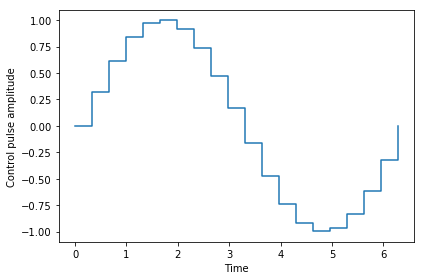

In [8]:
tlist = np.linspace(0., 2*np.pi, 20)
processor = Processor(N=1, spline_kind="step_func")
processor.add_control(sigmaz(), 0)
processor.pulses[0].tlist = tlist
processor.pulses[0].coeff = np.array([np.sin(t) for t in tlist])
processor.plot_pulses();

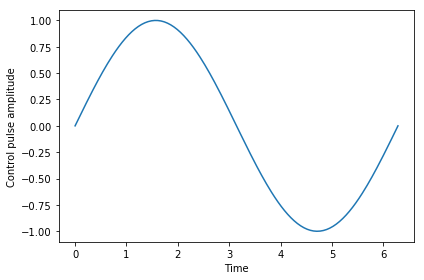

In [9]:
tlist = np.linspace(0., 2*np.pi, 20)
processor = Processor(N=1, spline_kind="cubic")
processor.add_control(sigmaz())
processor.pulses[0].tlist = tlist
processor.pulses[0].coeff = np.array([np.sin(t) for t in tlist])
processor.plot_pulses();

## Noisy evolution

In real quantum devices, noise affects the perfect execution of gate-based quantum circuits, limiting their depths. In general, we can divide quantum noise into two types: coherent and incoherent noise. The former one usually dues to the deviation of the control pulse. The noisy evolution is still unitary. Incoherent noise comes from the coupling of the quantum system with the environment. This type of noise leads to the loss of information. In QIP theory, we describe this type of noise with a noisy channel, corresponding to the collapse operators in the Lindblad equation.

Although noise can, in general, be simulated with quantum channel representation, it will need some pre-analysis and approximation, which can be difficult in a large system. This simulator offers an easier, but computationally more demanding solution from the viewpoint of quantum control. `Processor`, as a circuit simulator, is different from the common simulator of QIP, as it simulates the evolution of the qubits under the driving Hamiltonian. The noise will be defined according to the control pulses and the evolution will be calculated using QuTiP solvers. This enables one to define more complicated noise such as cross-talk and leakage error, depending on the physical device and the problem one wants to study. On the one hand, the simulation can help one analyze the noise composition and identify the dominant noise source. On the other hand, together with a backend compiler, one can also use it to study if an algorithm is sensitive to a certain type of noise.

### Decoherence

In `Processor`, decoherence noise is simulated by adding collapse operator into the Lindbladian equation. For single-qubit decoherence, it is equivalent to applying random bit flip and phase flip error after applying the quantum gate. For qubit relaxation, one can simply specify the $t_1$ and $t_2$ time for the device or for each qubit. Here we assume the qubit system has a drift Hamiltonian $H_d=\hbar \omega \sigma_z$, for simplicity, we let $\hbar \omega = 10$

In [10]:
a = destroy(2)
initial_state = basis(2,1)
plus_state = (basis(2,1) + basis(2,0)).unit()
tlist = np.arange(0.00, 2.02, 0.02)
H_d = 10.*sigmaz()

#### Decay time $T_1$
The $T_1$ relaxation time describes the strength of amplitude damping and can be described, in a two-level system, by a collapse operator $\frac{1}{\sqrt{T_1}}a$, where $a$ is the annihilation operator. This leads to an exponential decay of the population of excited states proportional to $\exp({-t/T_1})$. This amplitude damping can be simulated by specifying the attribute `t1` of the processor

In [11]:
from qutip.qip.pulse import Pulse
t1 = 1.
processor = Processor(1, t1=t1)
# creat a dummpy pulse that has no Hamiltonian, but only a tlist.
processor.add_pulse(Pulse(None, None, tlist=tlist, coeff=False))
result = processor.run_state(init_state=initial_state, e_ops=[a.dag()*a])

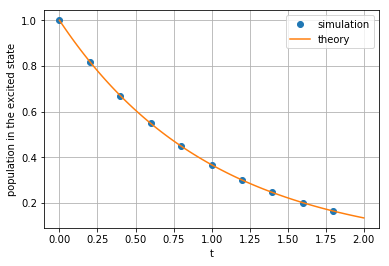

In [12]:
fig, ax = plt.subplots()
ax.plot(tlist[0: 100: 10], result.expect[0][0: 100: 10], 'o', label="simulation")
ax.plot(tlist, np.exp(-1./t1*tlist), label="theory")
ax.set_xlabel("t")
ax.set_ylabel("population in the excited state")
ax.legend()
plt.grid()

#### Decay time $T_2$
The $T_2$ time describes the dephasing process. Here one has to be careful that the amplitude damping channel characterized by $T_1$ will also lead to a dephasing proportional to $\exp(-t/2T_1)$. To make sure that the overall phase dampling is $exp(-t/T_2)$, the processor (internally) uses an collapse operator $\frac{1}{\sqrt{2*T'_2}} \sigma_z$ with $\frac{1}{T'_2}+\frac{1}{2T_1}=\frac{1}{T_2}$ to simulate the dephasing. (This also indicates that $T_2 \leqslant 2T_1$)

Usually, the $T_2$ time is measured by the Ramsey experiment, where the qubit starts from the excited state, undergoes a $\pi/2$ pulse, proceeds for a time $t$, and measured after another $\pi/2$ pulse. For simplicity, here we directly calculate the expectation value of $\rm{H}\circ a^\dagger a \circ\rm{H}$, where $\rm{H}$ denotes the Hadamard transformation. This is equivalent to measure the population of $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$. The envelope should follow an exponential decay characterized by $T_2$.

In [13]:
t1 = 1. 
t2 = 0.5
processor = Processor(1, t1=t1, t2=t2)
processor.add_control(H_d, 0)
processor.pulses[0].coeff = True
processor.pulses[0].tlist = tlist
Hadamard = hadamard_transform(1)
result = processor.run_state(init_state=plus_state, e_ops=[Hadamard*a.dag()*a*Hadamard])

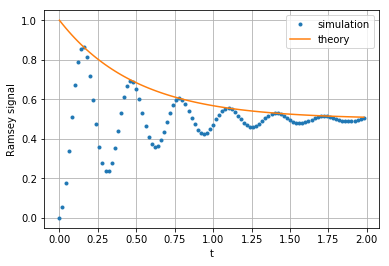

In [14]:
fig, ax = plt.subplots()
# detail about lenght of tlist needs to be fixed
ax.plot(tlist[:-1], result.expect[0][:-1], '.', label="simulation")
ax.plot(tlist[:-1], np.exp(-1./t2*tlist[:-1])*0.5 + 0.5, label="theory")
plt.xlabel("t")
plt.ylabel("Ramsey signal")
plt.legend()
ax.grid()

### Random noise in the pulse intensity

Despite single-qubit decoherence, `Processor` can also simulate coherent  control noise. For general types of noise, one can define a noise object and add it to the processor. An example of predefined noise is the random amplitude noise, where random value is added to the pulse every `dt`. `loc` and `scale` are key word arguments for the random number generator `np.random.normal`.

In [15]:
from qutip.qip.noise import RandomNoise
processor = Processor(N=1)
processor.add_control(0.5 * sigmaz(), targets=0, label="sigmaz")
processor.add_control(0.5 * sigmay(), targets=0, label="sigmay")
processor.coeffs = np.array([[1., 0., 1.],
                             [0., 1., 0.]])
processor.set_all_tlist(np.array([0., pi/2., 2*pi/2, 3*pi/2]))
processor_white = copy.deepcopy(processor)
processor_white.add_noise(RandomNoise(rand_gen=np.random.normal, dt=0.1, loc=-0.05, scale=0.02))  # gausian white noise

We again compare the result of the evolution with and without noise.

In [16]:
result = processor.run_state(init_state=basis(2, 1))
result.states[-1].tidyup(1.0e-5)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.7071043+0.j        ]
 [ 0.       +0.70710926j]]

In [17]:
result_white = processor_white.run_state(init_state=basis(2, 1))
result_white.states[-1].tidyup(1.0e-4)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.64493797-0.00204507j]
 [ 0.12023457+0.75471483j]]

In [18]:
fidelity(result.states[-1], result_white.states[-1])

0.9932265373557044

Since the result of this this noise is still a pure state, we can visualize it on a Bloch sphere

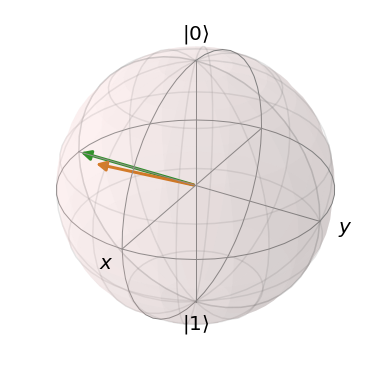

In [19]:
from qutip.bloch import Bloch
b = Bloch()
b.add_states([result.states[-1], result_white.states[-1]])
b.make_sphere()

We can print the pulse information to see the noise.

The ideal pulses:

In [20]:
for pulse in processor_white.pulses:
    pulse.print_info()

----------------------------------------------------------------------
Pulse label: sigmaz
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]], 'targets': [0], 'tlist': array([0.        , 1.57079633, 3.14159265, 4.71238898]), 'coeff': array([1., 0., 1.])}
----------------------------------------------------------------------
----------------------------------------------------------------------
Pulse label: sigmay
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j  0.-0.5j]
 [0.+0.5j 0.+0.j ]], 'targets': [0], 'tlist': array([0.        , 1.57079633, 3.14159265, 4.71238898]), 'coeff': array([0., 1., 0.])}
----------------------------------------------------------------------


And the noisy pulses:

In [21]:
for pulse in processor_white.get_noisy_pulses():
    pulse.print_info()

----------------------------------------------------------------------
Pulse label: sigmaz
The pulse contains: 1 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]], 'targets': [0], 'tlist': array([0.        , 1.57079633, 3.14159265, 4.71238898]), 'coeff': array([1., 0., 1.])}

Coherent noise:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]], 'targets': [0], 'tlist': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7]), 'coeff': array([-0.04111324, -0.06137941, -0.05426716, -0.04919859, -0.04264403,
       -0.02250504, -0.03375665, -0.05148854, -0.02148299, 

## Getting a `Pulse` or `QobjEvo` representation
If you define a complicate `Processor` but don't want to run the simulation right now, you can extract an ideal/noisy `Pulse` representation or `QobjEvo` representation. The later one can be feeded directly to QuTiP sovler for the evolution.

In [22]:
ideal_pulses = processor_white.pulses

In [23]:
noisy_pulses = processor_white.get_noisy_pulses(device_noise=True, drift=True)

In [24]:
qobjevo = processor_white.get_qobjevo(noisy=False)

In [25]:
noisy_qobjevo, c_ops = processor_white.get_qobjevo(noisy=True)

## Structure inside the simulator

The figures below help one understanding the workflow inside the simulator. The first figure shows how the noise is processed in the circuit processor. The noise is defined separately in a class object. When called, it takes parameters and the unitary noiseless `qutip.QobjEvo` from the processor, generates the noisy version and sends the noisy `qutip.QobjEvo` together with the collapse operators to the processor.

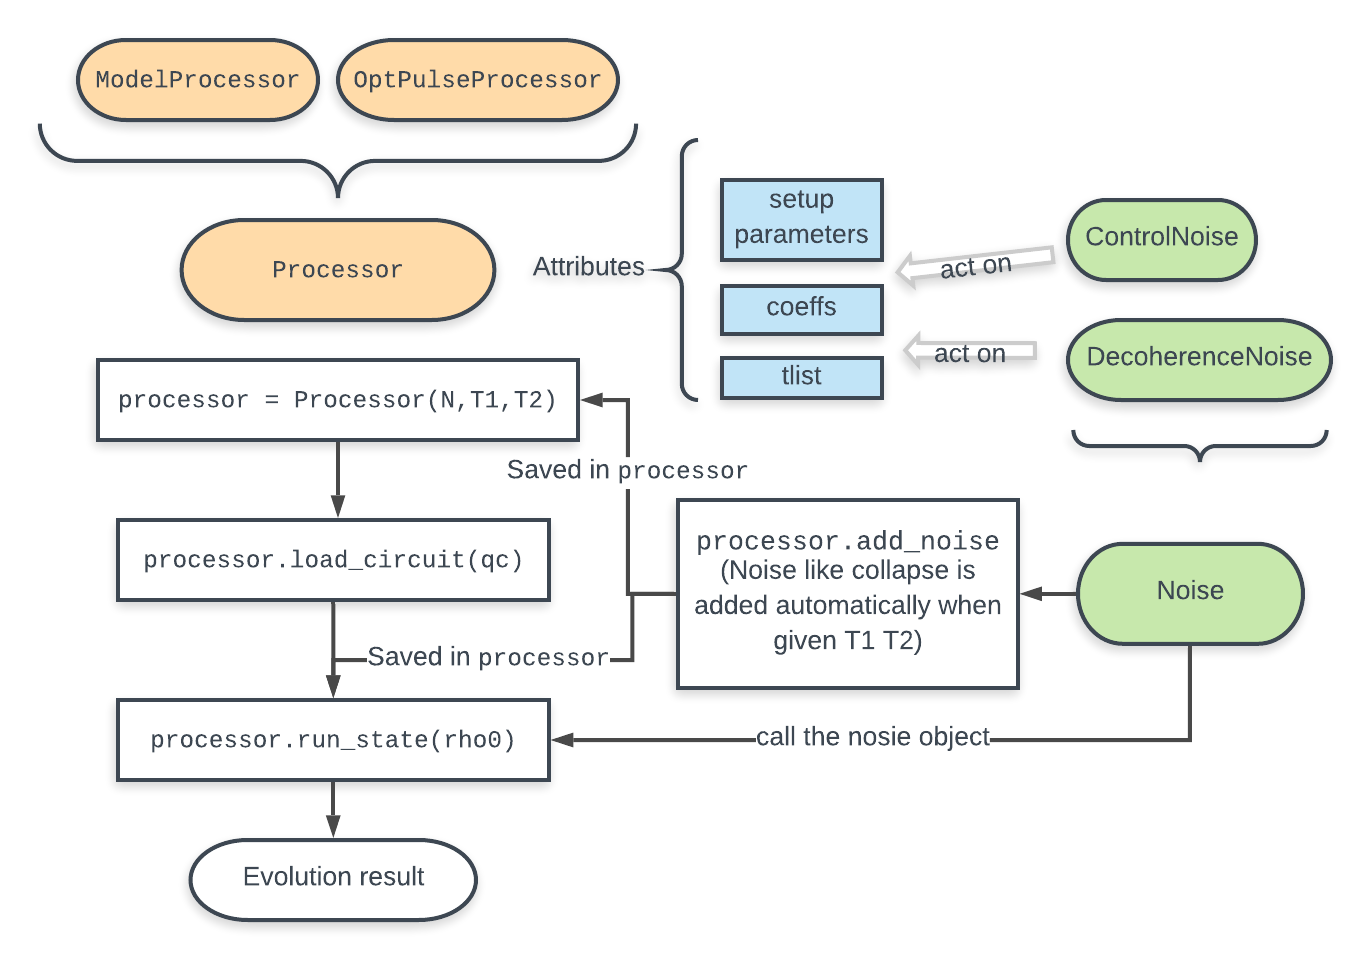

When calculating the evolution, the processor first creates its own `qutip.QobjEvo` of the noiseless evolution. It will then find all the noise objects saved in the attributes `qutip.qip.device.Processor.noise` and call the corresponding methods to get the `qutip.QobjEvo` and a list of collapse operators representing the noise. (For collapse operators, we don't want to add all the constant collapse into one time-independent operator, so we use a list). The processor then combines its own `qutip.QobjEvo` with those from the noise objects and give them to the solver. The figure below shows how the noiseless part and the noisy part are combined.

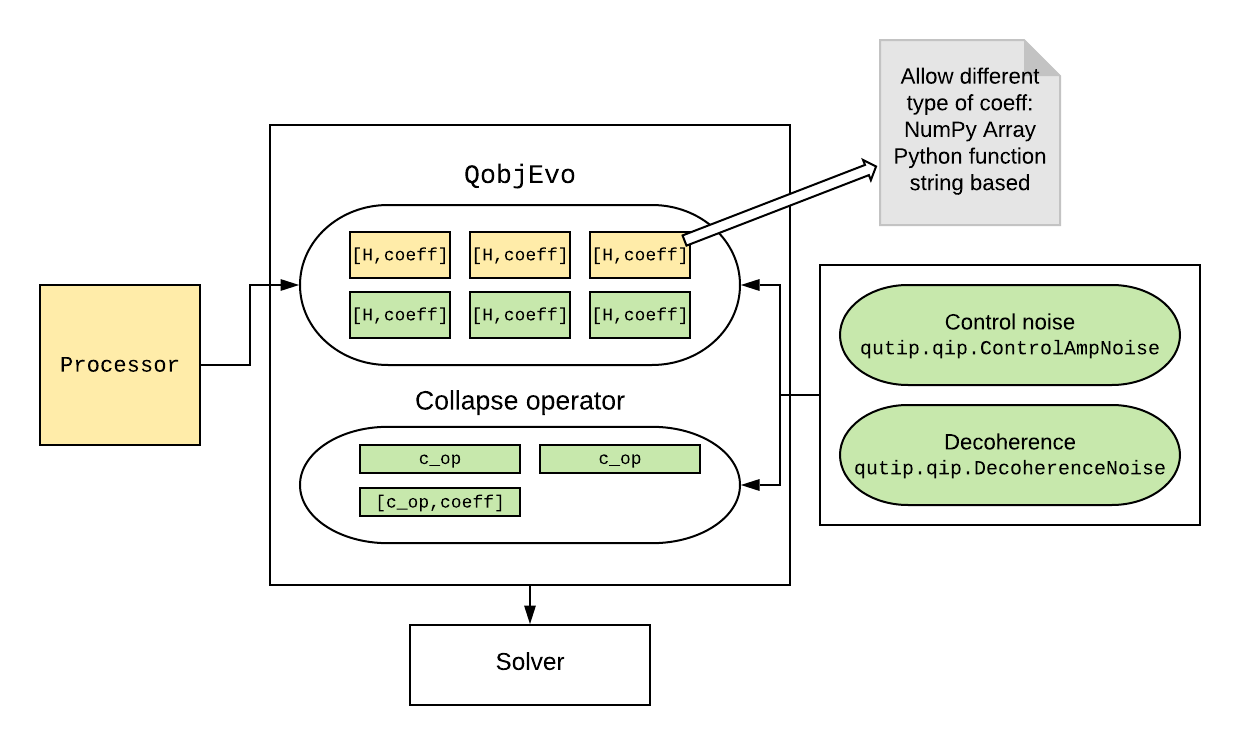

In [26]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.5.0.dev0+4ad874f6
Numpy,1.17.5
SciPy,1.2.1
matplotlib,2.2.4
Cython,0.29.14
Number of CPUs,12
BLAS Info,Generic
IPython,7.11.1
Python,"3.6.7 (default, Dec 6 2019, 07:03:06) [MSC v.1900 64 bit (AMD64)]"
OS,nt [win32]
